# Oeffikator

## Setup
We start off with global varibale and function definition and important imports.

In [2]:
import datetime
import geopy.distance
import json
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random 
import requests
import time

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [3]:
BVG_URL = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
# requires key, x and y coordinates
JSON_GEOLOC = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
# set travel date always to upcoming monday (!)
day = datetime.datetime.today()
while day.weekday()!= 0:
    day+=datetime.timedelta(1)
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
CMAP = mcolors.LinearSegmentedColormap('my_colormap', cdict, 100)

In [31]:
def request_data(json_string):
    data = json.loads(json_string)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(BVG_URL, data=json.dumps(data), headers=headers)
    return json.loads(r.text)
    
def query_location(query):
    print("query: ", query)
    params = (
        ('query', query),
        ('results', '1'),
        ('stops', 'false'),
        ('poi', 'false'),
    )
    return requests.get('https://v5.bvg.transport.rest/locations', params=params).json()[0]

def get_location_from_coordinates(coordinates):
    resp = request_data(JSON_GEOLOC % (key, to_BVG_sdt(coordinates[0]), to_BVG_sdt(coordinates[1])))
    return resp["svcResL"][1]["res"]["locL"][0]["name"]

def get_trip(start, destination):
    params = (
        ('from.address', start["address"]),
        ('from.latitude', start["latitude"]),
        ('from.longitude', start["longitude"]),
        ('to.address', destination["address"]),
        ('to.latitude', destination["latitude"]),
        ('to.longitude', destination["longitude"]),
        ('departure', day.strftime("%Y-%m-%dT11:00+00:00")),
        ('results', '1'),
        ('stopovers', 'true')
    )
    return requests.get('https://v5.bvg.transport.rest/journeys', params=params).json()

def write_entry(file_name, i, x, y, atime):
    with open("results/" + file_name,"a+") as f:
        f.write(str(i)+","+str(x)+","+str(y)+","+atime+"\n")

def compute_distance(x1,y1,x2,y2):
    return geopy.distance.distance((x1,y1), (x2,y2)).km

def to_BVG_sdt(x : float) -> int:
    return int(x*10E5)

class TimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, start_time="12000"):
        self.start_time = datetime.datetime.strptime("120000","%H%M%S")
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["Time"] = pd.to_datetime(X["Time"], format="%H%M%S")
        X["Time"] = X["Time"] - self.start_time
        X["Time"] = X["Time"].dt.total_seconds()/60
        X = X.dropna()
        X = X[X["Time"] > 0] # drop all items where time is negative
        #X = X.drop_duplicates(["X", "Y"])
        return X

## Get your authentification key
Before we get started, let's read or locally stored auth key.

In [5]:
with open("AUTHKEY.txt") as keyfile:
        key = keyfile.read().splitlines()[0]

## Crawl Data

Let's define some parameter first.

In [15]:
query = "maxstr. 5"
start = query_location(query)
print("We gonne use following address: " + start["address"])

query:  maxstr. 5
We gonne use following address: 13347 Berlin-Wedding, Maxstr. 5


In [42]:
file_name = str(to_BVG_sdt(start["longitude"])) + "_" + str(to_BVG_sdt(start["latitude"])) + ".csv"
# in format left, right, bottom, top
# or xmin, xmax, ymin, ymax
bounding_box = (13.2756, 13.4892, 52.4677, 52.5532)
step_size_x = 0.02
step_size_y = step_size_x / 2

print("X distance GPS: ",bounding_box[1]-bounding_box[0])
print("Y distance GPS: ", bounding_box[3]-bounding_box[2])

print("X distance km: ",compute_distance(bounding_box[0],bounding_box[2],bounding_box[1],bounding_box[2]))
print("Y distance km: ",compute_distance(bounding_box[1],bounding_box[2],bounding_box[1],bounding_box[3]))

length = len(np.arange(bounding_box[0],bounding_box[1],step_size_x)) * len(np.arange(bounding_box[2],bounding_box[3],step_size_y))
print("Amount of requests: ",length)
print("Estimated time: " + str(int(length*3.33/60)) + "min")

X distance GPS:  0.21359999999999957
Y distance GPS:  0.08549999999999613
X distance km:  23.6313760602401
Y distance km:  9.256943112258886
Amount of requests:  99
Estimated time: 5min


Check if there exists a file for this starting position.

In [53]:
all_files = os.listdir("results")    
csv_files = [file_name for file_name in all_files if file_name.endswith(".csv")]
if file_name in csv_files:
    with open("results/" + file_name, "r", encoding="utf-8", errors="ignore") as f:
        final_line = f.readlines()[-1]
    start_index = int(final_line.split(',')[0])
else:
    start_index = 0
start_index

189

And now let's get the points.

In [54]:
i = start_index 
destination_i = 0
for x in np.arange(bounding_box[0],bounding_box[1],step_size_x):
    for y in np.arange(bounding_box[2],bounding_box[3],step_size_y):
        destination_i+=1
        try:
            print(destination_i/length*100,"% Fortschritt, es fehlen",length - destination_i)
            destination = {"longitude": str(x), "latitude": str(y), "address": "placeholder"}
            print(x,y)
            time.sleep(60/50)
            response = get_trip(start,destination)
            for leg in response["journeys"][0]["legs"]:
                if "stopovers" in leg:
                    for stop in leg["stopovers"]:
                        if stop["arrival"] != None:
                            i+=1
                            x = stop["stop"]["location"]["longitude"]
                            y = stop["stop"]["location"]["latitude"]
                            atime = stop["arrival"][11:19].replace(":","")
                            write_entry(file_name, i, x, y, atime)
            i+=1
            write_entry(file_name, i, leg["destination"]["longitude"], leg["destination"]["latitude"], leg["arrival"][11:19].replace(":",""))
        except (ValueError, KeyError):
            with open("results/" + file_name,"a+") as f:
                f.write(str(i)+","+str(x)+","+str(y)+",error\n")
            continue

1.0101010101010102 % Fortschritt, es fehlen 98
13.2756 52.4677
2.0202020202020203 % Fortschritt, es fehlen 97
13.278407 52.4777
3.0303030303030303 % Fortschritt, es fehlen 96
13.280474 52.4877
4.040404040404041 % Fortschritt, es fehlen 95
13.284403 52.497699999999995
5.05050505050505 % Fortschritt, es fehlen 94
13.290147 52.50769999999999
6.0606060606060606 % Fortschritt, es fehlen 93
13.289778 52.51769999999999
7.07070707070707 % Fortschritt, es fehlen 92
13.284241 52.52769999999999
8.080808080808081 % Fortschritt, es fehlen 91
13.300134 52.53769999999999
9.090909090909092 % Fortschritt, es fehlen 90
13.300404 52.547699999999985
10.1010101010101 % Fortschritt, es fehlen 89
13.2956 52.4677
11.11111111111111 % Fortschritt, es fehlen 88
13.295199 52.4777
12.121212121212121 % Fortschritt, es fehlen 87
13.294614 52.4877
13.131313131313133 % Fortschritt, es fehlen 86
13.300718 52.497699999999995
14.14141414141414 % Fortschritt, es fehlen 85
13.301806 52.50769999999999
15.151515151515152 % F

(Different Method to generate directions https://stackoverflow.com/questions/57539749/find-out-centre-of-the-most-dense-region-in-a-scatter-plot )

In [55]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
# k = kde.gaussian_kde(data.T)
# xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))

Time to get the data.

## Plotting

Let's read data first.

In [56]:
file_name_plottting = "13365647_52548871.csv"
df = pd.read_csv("results/" + file_name_plottting, sep=",", index_col = 0, names=["X","Y","Time"],  na_values="None", dtype = {"X": np.float32, "Y": np.float32, "Time":str})

And then transform it with some custom pipelines.

In [57]:
time_transformer = TimeTransformer()
dfn = time_transformer.transform(df)

It's time to plot:

In [58]:
dfn = dfn.drop_duplicates()

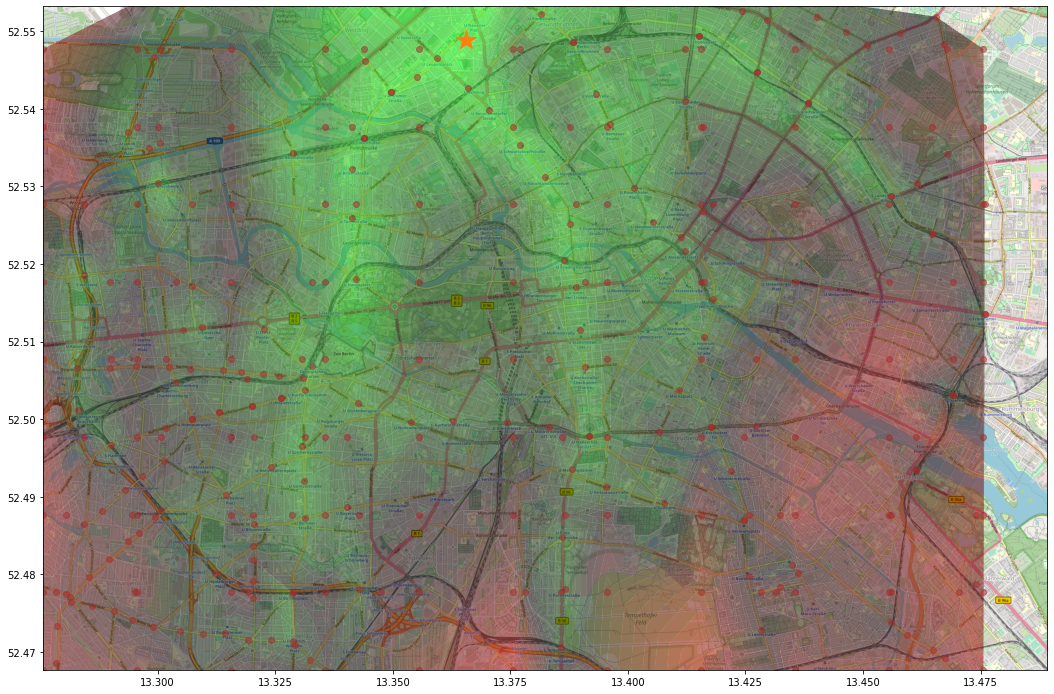

In [59]:
#get the start location coordinates from the file name
start_location = tuple([int(coordinate)*10E-7 for coordinate in file_name_plottting[:-4].split("_")])
# get the bounding box from the location
bounding_box_locations = (min(dfn["X"]), max(dfn["X"]), min(dfn["Y"]), max(dfn["Y"]))
# sets hard coded for the map "map_berlin_A.png"
bounding_box_map = (13.272, 13.491, 52.456, 52.563)
map = plt.imread('maps/map_berlin_A.png')
# define the amount of color levels should be there
levels = np.linspace(np.min(dfn["Time"]), 60, 32)

fig, ax = plt.subplots(figsize = (18,18))
ax.set_xlim(bounding_box[0],bounding_box[1])
ax.set_ylim(bounding_box[2],bounding_box[3])
ax.tricontourf(dfn["X"], dfn["Y"], dfn["Time"], levels=levels, alpha= 0.5, cmap = CMAP, antialiased=True)
#Displaying destination locations
ax.scatter(dfn["X"], dfn["Y"], alpha=0.5, color = "brown")

# "aspect=1.65" as a magic number
ax.imshow(map, extent = bounding_box_map, aspect = 1.65)
# plot the starting position
ax.plot(start_location[0], start_location[1], marker="*", markersize=20, color="tab:orange")

In [ ]:
plt.savefig("results/images/map_berlin_sWedding.png")

## Creating a map
This code is copied from following website: http://bigmap.osmz.ru/

In [ ]:
#!/usr/bin/env python
# Generated by BigMap 2. Permalink: http://bigmap.osmz.ru/bigmap.php?xmin=17592&xmax=17611&ymin=10740&ymax=10755&zoom=15&scale=256&tiles=osm-de

import io, urllib.request, datetime, time, re, random
from PIL import Image, ImageDraw
# ^^^^^^ install "python-pillow" package | pip install Pillow | easy_install Pillow

(zoom, xmin, ymin, xmax, ymax) = (15, 17592, 10740, 17611, 10755)
layers = ["https://{abc}.tile.openstreetmap.de/tiles/osmde/!z/!x/!y.png"]
attribution = 'Map data (c) OpenStreetMap, Tiles (c) OSM DE'
xsize = xmax - xmin + 1
ysize = ymax - ymin + 1
tilesize = 256

resultImage = Image.new("RGBA", (xsize * tilesize, ysize * tilesize), (0,0,0,0))
counter = 0
for x in range(xmin, xmax+1):
	for y in range(ymin, ymax+1):
		for layer in layers:
			url = layer.replace("!x", str(x)).replace("!y", str(y)).replace("!z", str(zoom))
			match = re.search("{([a-z0-9]+)}", url)
			if match:
				url = url.replace(match.group(0), random.choice(match.group(1)))
			print(url, "... ");
			try:
				req = urllib.request.Request(url, headers={'User-Agent': 'BigMap/2.0'})
				tile = urllib.request.urlopen(req).read()
			except Exception as e:
				print("Error", e)
				continue;
			image = Image.open(io.BytesIO(tile))
			resultImage.paste(image, ((x-xmin)*tilesize, (y-ymin)*tilesize), image.convert("RGBA"))
			counter += 1
			if counter == 10:
				time.sleep(2);
				counter = 0

draw = ImageDraw.Draw(resultImage)
draw.text((5, ysize*tilesize-15), attribution, (0,0,0))
del draw

now = datetime.datetime.now()
outputFileName = "maps/map_Berlin_A_high.png"# % (zoom, now.year % 100, now.month, now.day, now.hour, now.minute)
resultImage.save(outputFileName)

## Previous code

In [ ]:
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
s1 = s1 % (key,13430400,52536099)
data = json.loads(s1)
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)
#print(r.text)
resp = json.loads(r.text)
resp["svcResL"][1]['res']['locL'][0]['lid']

In [ ]:
rp = """{"ver":"1.18","ext":"BVG.1","lang":"eng","id":"tm2ktgxukkk3y2wg","err":"OK","svcResL":[{"meth":"ServerInfo","err":"OK","res":{"common":{"locL":[],"prodL":[],"polyL":[],"layerL":[{"id":"standard","name":"standard","index":0,"annoCnt":0}],"crdSysL":[{"id":"standard","index":0,"type":"WGS84"}],"opL":[],"remL":[],"icoL":[]},"sD":"20220202","sT":"114242","enc":"ISO-8859-1","planrtTS":"1643798528"}},{"meth":"LocGeoPos","err":"OK","res":{"common":{"locL":[],"prodL":[{"pid":"L::2::Tram::B3041857784::Tram_3041857784_M10::*","name":"M10","nameS":"M10","icoX":0,"cls":4,"prodCtx":{"name":"M10","line":"M10","lineId":"M10","catOut":"Tram    ","catOutS":"T","catOutL":"Tram    "},"himIdL":["HIM_FREETEXT_75748","HIM_FREETEXT_52249"]}],"polyL":[],"layerL":[{"id":"standard","name":"standard","index":0,"annoCnt":0}],"crdSysL":[{"id":"standard","index":0,"type":"WGS84"}],"opL":[],"remL":[],"icoL":[{"res":"prod_gen"},{"res":"POI"}]},"locL":[{"lid":"A=4@O=Berlin, Theater unterm Dach@X=13430936@Y=52537482@u=158@U=104@L=900980701@","type":"P","name":"Berlin, Theater unterm Dach","icoX":1,"extId":"900980701","state":"F","crd":{"x":13430936,"y":52537482,"layerX":0,"crdSysX":0},"dist":158,"dur":309}]}}]}
"""
resp = json.loads(rp)
a = resp["svcResL"][1]['res']['locL'][0]['extId']
b = resp["svcResL"][1]['res']['locL'][0]['type']
print(a,b)

resp

In [ ]:
import geopy.distance

F = 10E-7
def distance(x,y,x2,y2):
    coords_1 = (y*F, x*F)
    coords_2 = (y2*F, x2*F)
    return geopy.distance.distance(coords_1, coords_2).km


F = 10E-7
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
s1 = s1 % (key)
teststops = []
for x in range(13440000,13490000,2000):
    print(x)
    y= 52536099
    
    s1_con = s1 % (x,y)
    print(distance(x*F,y*F,13430400*F,52536099*F))
    data = json.loads(s1_con)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    stop = resp["svcResL"][1]['res']['locL'][0]['lid']
    teststops.append(stop)

In [ ]:
teststops

In [ ]:
#messung wie weit die generierte station und die urpsprünglichen koordinaten auseinander liegen
#ist 350m wenig genug?
distance(13355768,52635339,13350744,52636099)

In [ ]:
distance(13355000*F,52635000*F,13357000*F,52635000*F)*1000

In [ ]:
import json
import requests
url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"TripSearch","cfg":{"polyEnc":"GPA"},"req":{"depLocL":[{"type":"P","lid":"A=4@O=Berlin, Prenzlkasper@X=13424679@Y=52536107@u=109@U=104@L=900980734@"}],"arrLocL":[{"type":"S","extId":"900200507"}],"outDate":"20220202","outTime":"120000","outFrwd":true,"gisFltrL":[{"mode":"FB","profile":{"type":"F","linDistRouting":false,"maxdist":2000},"type":"M","meta":"foot_speed_normal"}],"getPolyline":true,"getPasslist":true,"getConGroups":false,"getIST":false,"getEco":false,"extChgTime":-1}}],"formatted":false}'
s1 = s1 % (key)
#s1 = s1 % (13430400,52536099)
data = json.loads(s1)
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)
#print(r.text)
resp = json.loads(r.text)
for x in range(len(resp['svcResL'][1]['res']['outConL'])):
    print(resp['svcResL'][1]['res']['outConL'][x]['arr']['aTimeS'])

    print("")

In [ ]:
length = len(range(13368007,13390623,2000)) * len(range(52518214,52523802,2000))
length2 = len(range(13368007,13390623,2000)) * len(range(52518214,52543802,2000))
print(length)
print(length2)

In [ ]:
import geopy.distance

import json
import requests
#test setup: x,y
#punkt 1:52523802, 13368007
#punkt 2:52518214, 13390623
#startpunkt beier
#punkt 3:52541350,  13366540
# x sind die 13er zahlen
F = 10E-7
def distance(x,y,x2,y2):
    coords_1 = (y*F, x*F)
    coords_2 = (y2*F, x2*F)
    return geopy.distance.distance(coords_1, coords_2).km



quit()
atimes = []
i =0

#links oben moabit 52.53746136684121, 13.31176629214652
#rechts unten moabit 52.51996891399787, 13.366440440707555
#xxxxxxxxxx
X1=13311766
Y1=52519960


X2=13366440
Y2=52537461

print("X distance gps",X2-X1)
print("Y distance gps", Y2-Y1)

print("X distance km",distance(X1,Y1,X2,Y1))
print("Y distance km",distance(X2,Y1,X2,Y2))

length = len(range(X1,X2,2000)) * len(range(Y1,Y2,2000))
print("anzahl berechnungen:",length)

start_lid = get_lid(13366540,52541350)
print(start_lid)


for x in range(13368007,13390623,2000):
    for y in range(52518214,52543802,2000):
        try:
            print(x,y)
            i+=1
            print(i/length*100,"% Fortschritt, es fehlen ",length - i)

            dest = get_dest(x,y)
            #print(get_lid(x,y))
            print("destination paramteres:",dest)
            time = get_traveltime(start_lid,dest)
            print(time)
            f = open("results3.txt","a+")
            f.write(str(x)+","+str(y)+","+str(i)+","+str(time)+"\n")
            f.close()

            #print(distance(13366540,52541350,x,y))
            atimes.append((x,y,time))
        except ValueError:
            with open("results3.txt","a+") as f:
                f.write("error"+str(i)+",x="+str(x)+", "+str(y)+"\n")

            continue
            
            
            

In [ ]:
def get_lid(x,y):
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
    s1 = s1 % (key,x,y)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    return resp["svcResL"][1]['res']['locL'][0]['lid']

def get_dest(x,y):
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"LocGeoPos","cfg":{"polyEnc":"GPA"},"req":{"ring":{"cCrd":{"x":%d,"y":%d},"maxDist":20000},"getStops":true,"getPOIs":true,"maxLoc":1}}],"formatted":false}'
    s1 = s1 % (key,x,y)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    e = resp["svcResL"][1]['res']['locL'][0]['extId']
    t = resp["svcResL"][1]['res']['locL'][0]['type']
    return (e,t)

def get_traveltime(start_lid,dest):
    extId = dest[0]
    dest_type = dest[1]
    url = "http://bvg-apps-ext.hafas.de/bin/mgate.exe/mgate.exe"
    s1 = '{"auth":{"aid":"%s","type":"AID"},"client":{"id":"BVG","type":"AND"},"ext":"BVG.1","ver":"1.18","lang":"eng","svcReqL":[{"meth":"ServerInfo","req":{"getServerDateTime":true,"getTimeTablePeriod":false}},{"meth":"TripSearch","cfg":{"polyEnc":"GPA"},"req":{"depLocL":[{"type":"P","lid":"%s"}],"arrLocL":[{"type":"%s","extId":"%s"}],"outDate":"20220202","outTime":"120000","outFrwd":true,"gisFltrL":[{"mode":"FB","profile":{"type":"F","linDistRouting":false,"maxdist":2000},"type":"M","meta":"foot_speed_normal"}],"getPolyline":true,"getPasslist":true,"getConGroups":false,"getIST":false,"getEco":false,"extChgTime":-1}}],"formatted":false}'
    #s1: 1. lid, 2. type, 3. extId
    s1 = s1 % (key,start_lid,dest_type, extId)
    data = json.loads(s1)
    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    r = requests.post(url, data=json.dumps(data), headers=headers)
    #print(r.text)
    resp = json.loads(r.text)
    #for x in range(len(resp['svcResL'][1]['res']['outConL'])):
    try:
        aTime = resp['svcResL'][1]['res']['outConL'][0]['arr']['aTimeS']
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])
    except:
        print("error!")
        print(resp)
        return None
    if aTime == None:
        print(resp['svcResL'][1]['res']['outConL'][0]['arr'])

        return None
    return int(aTime)


In [ ]:
with open("results2.txt") as r:
        X = []
        Y = []
        L = []
        for l in r:
            if "error" in l:
                continue
            x = l.split(",")[0]
            y = l.split(",")[1]
            time = l.split(",")[3]
            hour = time[0:2]
            minutes = time[2:4]
            length = int(minutes) + (int(hour) - 12)*60
            #print(length)
            X.append(int(x))
            Y.append(int(y))
            L.append(length)

In [ ]:
len(L)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sys import argv
import matplotlib.pyplot as plt
ax = plt.axes(projection='3d')
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
import numpy as np
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.scatter3D(np.array(X),np.array(Y),np.array(length))

#ax.scatter3D(X,Y,L,c=L)

fig = plt.figure()
ax = Axes3D(fig)
ax.view_init(azim=180)

surf = ax.plot_trisurf(X, Y, L, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('teste.pdf')
plt.show()



print("Making animation")
